## ProjF5 - Final Model

* **Please be advised that all models have been re-executed, and as a result, there may be slight variations in the outcomes compared to those presented in the slides.**

* **Our models are LSTM+CNN and BiLSTM+CNN**






In [73]:
#Importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Concatenate, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 1. Load and Prepare Data

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
#Reading data as a DataFrame
data = pd.read_csv('/content/drive/MyDrive/NNDL/sales_prediction_data.csv')

In [76]:
data

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0
...,...,...,...,...
957995,2018-03-27,10,50,NaN
957996,2018-03-28,10,50,NaN
957997,2018-03-29,10,50,NaN
957998,2018-03-30,10,50,NaN


In [77]:
#Checking for duplicate rows in the dataset
print("Duplicate rows:", data.duplicated().sum())

Duplicate rows: 0


In [78]:
#Converting 'date' attribute to date type
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


In [79]:
#Checking for null values in the dataset
data.isna().sum()

date         0
store        0
item         0
sales    45000
dtype: int64

In [80]:
#Correlation of each attribute with sales
corr = data.corr()
corr['sales'].sort_values(ascending=False)


sales    1.000000
date     0.195909
store   -0.008170
item    -0.055998
Name: sales, dtype: float64

Since none of the attributes individually exhibit a strong correlation with sales, we have decided to include all attributes in the model. By considering them together, we aim to capture potential interactions and dependencies between the attributes, which can contribute to the effectiveness of the model during training.

In [81]:
'''Sorting the data according to date as it is a time-stamped dataset and it
would be convinient for traininig the models on sorted data'''

data = data.sort_values('date')

In [82]:
'''It can be seen that all the null values for sales are from 2018-01-01 to
2018-03-31 as the goal of the competition, from where this dataset is obtained,
is to predict the sales of the stores during this time period using historical
data'''

data[data['sales'].isna()]

,date,store,item,sales
951880,2018-01-01,3,44,NaN
923530,2018-01-01,8,12,NaN
939640,2018-01-01,7,30,NaN
932080,2018-01-01,3,22,NaN
931990,2018-01-01,2,22,NaN
...,...,...,...,...
926229,2018-03-31,7,15,NaN
926139,2018-03-31,6,15,NaN
926049,2018-03-31,5,15,NaN
926949,2018-03-31,5,16,NaN


In [83]:
#Storing the rows where sales need to be predicted in y (test set)
y = data[data['sales'].isna()]


In [84]:
y

,date,store,item,sales
951880,2018-01-01,3,44,NaN
923530,2018-01-01,8,12,NaN
939640,2018-01-01,7,30,NaN
932080,2018-01-01,3,22,NaN
931990,2018-01-01,2,22,NaN
...,...,...,...,...
926229,2018-03-31,7,15,NaN
926139,2018-03-31,6,15,NaN
926049,2018-03-31,5,15,NaN
926949,2018-03-31,5,16,NaN


In [85]:
data = data.drop(y.index)

In [86]:
data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [87]:
#Storing the rest of the data in X (train set)
X = data
X = X.reset_index(drop=True)

In [88]:
#Printing the train set
X

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-01,3,40,16.0
2,2013-01-01,2,40,20.0
3,2013-01-01,3,6,34.0
4,2013-01-01,1,40,19.0
...,...,...,...,...
912995,2017-12-31,3,24,100.0
912996,2017-12-31,2,47,24.0
912997,2017-12-31,3,2,68.0
912998,2017-12-31,2,1,31.0


In [89]:
#Printing the test set
y = y.reset_index(drop=True)
y

,date,store,item,sales
0,2018-01-01,3,44,NaN
1,2018-01-01,8,12,NaN
2,2018-01-01,7,30,NaN
3,2018-01-01,3,22,NaN
4,2018-01-01,2,22,NaN
...,...,...,...,...
44995,2018-03-31,7,15,NaN
44996,2018-03-31,6,15,NaN
44997,2018-03-31,5,15,NaN
44998,2018-03-31,5,16,NaN


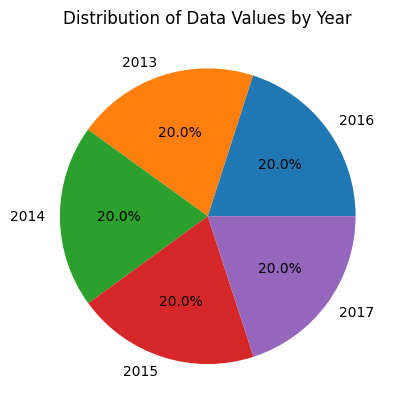

In [90]:
#Data distribution for each year in train set
X['year'] = X['date'].dt.year


year_counts = X['year'].value_counts()

plt.pie(year_counts, labels=year_counts.index, autopct='%1.1f%%')


plt.title('Distribution of Data Values by Year')


plt.show()


As we can see, we do not have any data imbalance in the train set. The data is distributed uniformly for each year.

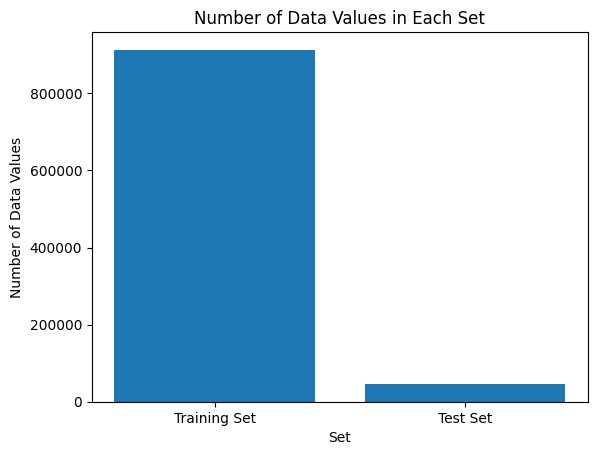

In [91]:
#Bar plot for showing the data distribution in train and test split

num_train = X.shape[0]
num_test = y.shape[0]

plt.bar(['Training Set', 'Test Set'], [num_train, num_test])

plt.title('Number of Data Values in Each Set')
plt.xlabel('Set')
plt.ylabel('Number of Data Values')

plt.show()


### 2. Preparing your Final Model

#BiLSTM

In [92]:
X_bilstm = X

In [93]:
X_bilstm

,date,store,item,sales,year
0,2013-01-01,1,1,13.0,2013
1,2013-01-01,3,40,16.0,2013
2,2013-01-01,2,40,20.0,2013
3,2013-01-01,3,6,34.0,2013
4,2013-01-01,1,40,19.0,2013
...,...,...,...,...,...
912995,2017-12-31,3,24,100.0,2017
912996,2017-12-31,2,47,24.0,2017
912997,2017-12-31,3,2,68.0,2017
912998,2017-12-31,2,1,31.0,2017


In [94]:
# Converting 'date' column to ordinal to use it as a feature
X_bilstm['date'] = X_bilstm['date'].apply(lambda x: x.toordinal())

In [95]:
X_bilstm

,date,store,item,sales,year
0,734869,1,1,13.0,2013
1,734869,3,40,16.0,2013
2,734869,2,40,20.0,2013
3,734869,3,6,34.0,2013
4,734869,1,40,19.0,2013
...,...,...,...,...,...
912995,736694,3,24,100.0,2017
912996,736694,2,47,24.0,2017
912997,736694,3,2,68.0,2017
912998,736694,2,1,31.0,2017


In [99]:
# Dropping 'year' column as it is redundant
X_bilstm.drop(columns=['year'], inplace=True)

In [97]:
# Feature scaling
scaler = MinMaxScaler()
X_bilstm[['date', 'store', 'item']] = scaler.fit_transform(X_bilstm[['date', 'store', 'item']])
y = scaler.fit_transform(X_bilstm[['sales']])

In [ ]:
# Defining function to create sequences
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
# Creating sequences for BiLSTM model
X_seq, y_seq = create_sequences(X_bilstm[['date', 'store', 'item']].values, y)

# Splitting the dataset into train and test sets
X_train_bilstm, X_test_bilstm, y_train_bilstm, y_test_bilstm = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
#Using the same number of BiLSTM units as LSTM used in Baseline report for fair comparision

bilstm_model = Sequential([
    Bidirectional(LSTM(units=50, activation='relu'), input_shape=(X_train_bilstm.shape[1], X_train_bilstm.shape[2])),
    Dense(units=1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Training the model (using the same epoch and batch size as Baseline for fair comparision)
bilstm_model.fit(X_train_bilstm, y_train_bilstm, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
20543/20543 [==============================] - 318s 15ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 2/25
20543/20543 [==============================] - 303s 15ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 3/25
20543/20543 [==============================] - 300s 15ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 4/25
20543/20543 [==============================] - 300s 15ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 5/25
20543/20543 [==============================] - 305s 15ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 6/25
20543/20543 [==============================] - 299s 15ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 7/25
20543/20543 [==============================] - 306s 15ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 8/25
20543/20543 [==============================] - 298s 15ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 9/25
20543/20543 [==============================] - 301s 15ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 10/25
20543/20543 [============

In [ ]:
from tensorflow.keras.models import load_model
# Save the model
bilstm_model.save("bilstm_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
bisltm_model = load_model("/content/bilstm_model.h5")

In [ ]:
# Evaluating the model
test_loss_bilstm = bisltm_model.evaluate(X_test_bilstm, y_test_bilstm)
print("Test Loss:", test_loss_bilstm)

5707/5707 [==============================] - 23s 4ms/step - loss: 0.0135
Test Loss: 0.013485914096236229


#LSTM+CNN (Our Model)

In [21]:
X_hyb = X

In [22]:
# Converting 'date' column to ordinal to use it as a feature
X_hyb['date'] = X_hyb['date'].apply(lambda x: x.toordinal())

In [23]:
# Dropping 'year' column as it is redundant
X_hyb.drop(columns=['year'], inplace=True)

In [24]:
# # One-hot encode 'store' column
# one_hot_encoded = pd.get_dummies(X_hyb['store'], prefix='store')

# # Convert True/False to 1/0
# one_hot_encoded = one_hot_encoded.astype(int)

# # Concatenate one-hot encoded columns to the original DataFrame
# X_hyb = pd.concat([X_hyb.drop('store', axis=1), one_hot_encoded], axis=1)

In [25]:
X_hyb

,date,store,item,sales
0,734869,1,1,13.0
1,734869,3,40,16.0
2,734869,2,40,20.0
3,734869,3,6,34.0
4,734869,1,40,19.0
...,...,...,...,...
912995,736694,3,24,100.0
912996,736694,2,47,24.0
912997,736694,3,2,68.0
912998,736694,2,1,31.0


In [26]:
# Feature scaling
scaler = MinMaxScaler()
X_hyb.loc[:, X_hyb.columns != 'sales'] = scaler.fit_transform(X_hyb.loc[:, X_hyb.columns != 'sales'])
y = scaler.fit_transform(X_hyb[['sales']])

In [27]:
# Defining function to create sequences
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [28]:
# Creating sequences for LSTM+CNN model
X_seq, y_seq = create_sequences(X_hyb[['date', 'store', 'item']].values, y)

# Splitting the dataset into train and test sets
X_train_hyb, X_test_hyb, y_train_hyb, y_test_hyb = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [29]:
y_train_hyb

array([[0.11255411],
       [0.05194805],
       [0.23809524],
       ...,
       [0.24675325],
       [0.12121212],
       [0.25974026]])

In [30]:
# Define input layers for LSTM and CNN models
lstm_input = Input(shape=(X_train_hyb.shape[1], X_train_hyb.shape[2]))
cnn_input = Input(shape=(X_train_hyb.shape[1], X_train_hyb.shape[2]))

# LSTM model
lstm_output = LSTM(units=50, activation='relu')(lstm_input)

# CNN model
cnn_output = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_output = MaxPooling1D(pool_size=2)(cnn_output)
cnn_output = Flatten()(cnn_output)

# Concatenate the outputs of LSTM and CNN models
concatenated = Concatenate()([lstm_output, cnn_output])

# Combine with dense layers
combined = Dense(64, activation='relu')(concatenated)
output = Dense(1)(combined)

# Define the ensemble model
ensemble_model = Model(inputs=[lstm_input, cnn_input], outputs=output)

# Compile the model
ensemble_model.compile(optimizer='adam', loss='mse')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("ensemble_model_checkpoint.h5", monitor='val_loss', save_best_only=True)

# Train the model
history = ensemble_model.fit([X_train_hyb, X_train_hyb], y_train_hyb, epochs=50, batch_size=256, validation_data=([X_test_hyb, X_test_hyb], y_test_hyb), callbacks=[early_stopping, checkpoint])



Epoch 1/50
2854/2854 [==============================] - 37s 11ms/step - loss: 0.0153 - val_loss: 0.0148
Epoch 2/50
  11/2854 [..............................] - ETA: 30s - loss: 0.0143

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2854/2854 [==============================] - 32s 11ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 3/50
2854/2854 [==============================] - 36s 12ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4/50
2854/2854 [==============================] - 35s 12ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 5/50
2854/2854 [==============================] - 33s 11ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 6/50
2854/2854 [==============================] - 34s 12ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 7/50
2854/2854 [==============================] - 30s 11ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 8/50
2854/2854 [==============================] - 38s 13ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 9/50
2854/2854 [==============================] - 41s 14ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 10/50
2854/2854 [==============================] - 34s 12ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 11/50
2854/2854 [==============================] - 30s 11ms/step - l

In [31]:
# # Load the best model from checkpoint
# from tensorflow.keras.models import load_model
# hyb_model = load_model("ensemble_model_checkpoint.h5")
# hyb_model.save("ensemble_model.h5")


In [32]:
# Evaluate the model on the test set
test_loss_ensemble = ensemble_model.evaluate([X_test_hyb, X_test_hyb], y_test_hyb)

print("Test Loss:", test_loss_ensemble)


5707/5707 [==============================] - 18s 3ms/step - loss: 0.0135
Test Loss: 0.013460875488817692


#BiLSTM+CNN (Our Model)

In [52]:
X_bcnn = X

In [53]:
X_bcnn

,date,store,item,sales,year
0,2013-01-01,1,1,13.0,2013
1,2013-01-01,3,40,16.0,2013
2,2013-01-01,2,40,20.0,2013
3,2013-01-01,3,6,34.0,2013
4,2013-01-01,1,40,19.0,2013
...,...,...,...,...,...
912995,2017-12-31,3,24,100.0,2017
912996,2017-12-31,2,47,24.0,2017
912997,2017-12-31,3,2,68.0,2017
912998,2017-12-31,2,1,31.0,2017


In [54]:
# Converting 'date' column to ordinal to use it as a feature
X_bcnn['date'] = X_bcnn['date'].apply(lambda x: x.toordinal())

In [55]:
# Dropping 'year' column as it is redundant
X_bcnn.drop(columns=['year'], inplace=True)

In [56]:
# X_encoded = pd.get_dummies(X_gru, columns=['store', 'item'], dtype=int)

# # Drop the original 'date' column if you don't need it
# X_encoded.drop(columns=['date'], inplace=True)

In [57]:
X_bcnn

,date,store,item,sales
0,734869,1,1,13.0
1,734869,3,40,16.0
2,734869,2,40,20.0
3,734869,3,6,34.0
4,734869,1,40,19.0
...,...,...,...,...
912995,736694,3,24,100.0
912996,736694,2,47,24.0
912997,736694,3,2,68.0
912998,736694,2,1,31.0


In [58]:
# Feature scaling
scaler = MinMaxScaler()

X_scaled = X_bcnn.iloc[:, :-1]

X_scaled.iloc[:, :] = scaler.fit_transform(X_scaled)

X_bcnn.iloc[:, :-1] = X_scaled
y = scaler.fit_transform(X_bcnn[['sales']])

In [59]:
X_bcnn

,date,store,item,sales
0,0.0,0.000000,0.000000,13.0
1,0.0,0.222222,0.795918,16.0
2,0.0,0.111111,0.795918,20.0
3,0.0,0.222222,0.102041,34.0
4,0.0,0.000000,0.795918,19.0
...,...,...,...,...
912995,1.0,0.222222,0.469388,100.0
912996,1.0,0.111111,0.938776,24.0
912997,1.0,0.222222,0.020408,68.0
912998,1.0,0.111111,0.000000,31.0


In [60]:
# Defining function to create sequences
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [61]:
# Creating sequences for GRU+CNN model
X_seq, y_seq = create_sequences(X_bcnn.drop(columns=['sales']).values, y)

# Splitting the dataset into train and test sets
X_train_bcnn, X_test_bcnn, y_train_bcnn, y_test_bcnn = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [66]:
# Define input layers for BiLSTM and CNN models
bilstm_input = Input(shape=(X_train_bcnn.shape[1], X_train_bcnn.shape[2]))
cnn_input = Input(shape=(X_train_bcnn.shape[1], X_train_bcnn.shape[2]))

# BiLSTM model
lstm_layer = LSTM(units=50, activation='relu')
bilstm_output = Bidirectional(lstm_layer)(bilstm_input)

# CNN model
cnn_output = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_output = MaxPooling1D(pool_size=2)(cnn_output)
cnn_output = Flatten()(cnn_output)

# Concatenate the outputs of BiLSTM and CNN models
concatenated = Concatenate()([bilstm_output, cnn_output])

# Combine with dense layers
combined = Dense(64, activation='relu')(concatenated)
output = Dense(1)(combined)

# Define the ensemble model
ensemble_model_blstm = Model(inputs=[bilstm_input, cnn_input], outputs=output)

# Compile the model
ensemble_model_blstm.compile(optimizer='adam', loss='mse')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("ensemble_model__blstm_checkpoint.h5", monitor='val_loss', save_best_only=True)

# Train the model
history = ensemble_model_blstm.fit([X_train_hyb, X_train_hyb], y_train_hyb, epochs=50, batch_size=256, validation_data=([X_test_bcnn, X_test_bcnn], y_test_hyb), callbacks=[early_stopping, checkpoint])


Epoch 1/50
2854/2854 [==============================] - 54s 18ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 2/50
   9/2854 [..............................] - ETA: 39s - loss: 0.0150

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2854/2854 [==============================] - 48s 17ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 3/50
2854/2854 [==============================] - 49s 17ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 4/50
2854/2854 [==============================] - 48s 17ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 5/50
2854/2854 [==============================] - 48s 17ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 6/50
2854/2854 [==============================] - 48s 17ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 7/50
2854/2854 [==============================] - 48s 17ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 8/50
2854/2854 [==============================] - 49s 17ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 9/50
2854/2854 [==============================] - 47s 17ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 10/50
2854/2854 [==============================] - 49s 17ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 11/50
2854/2854 [==============================] - 47s 17ms/step - l

In [68]:
# Evaluate the model on the test set
test_loss_bilstm = ensemble_model_blstm.evaluate([X_test_bcnn, X_test_bcnn], y_test_bcnn)

print("Test Loss:", test_loss_bilstm)


5707/5707 [==============================] - 23s 4ms/step - loss: 0.0135
Test Loss: 0.013477363623678684


### 3. Model Performance

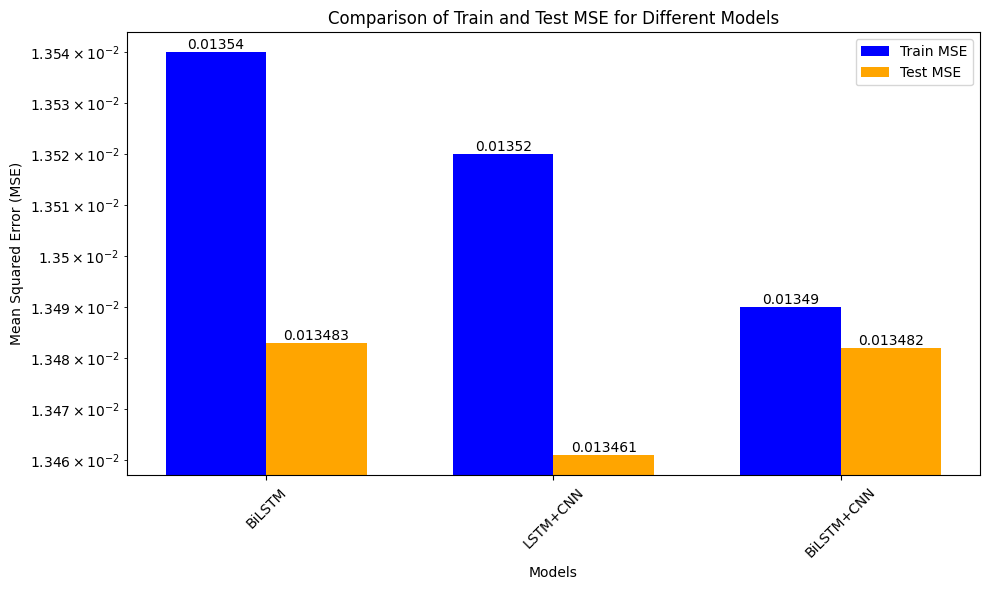

In [69]:
import matplotlib.pyplot as plt
import numpy as np

models = ['BiLSTM', 'LSTM+CNN', 'BiLSTM+CNN']

# Train MSE values
train_mse = [0.01354, 0.01352, 0.01349]

# Test MSE values
test_mse = [0.013483, 0.013461, 0.013482]

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(models))

bars1 = plt.bar(index, train_mse, bar_width, color='blue', label='Train MSE')
bars2 = plt.bar(index + bar_width, test_mse, bar_width, color='orange', label='Test MSE')

plt.yscale('log')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Train and Test MSE for Different Models')
plt.legend()
plt.xticks(index + bar_width / 2, models, rotation=45)

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 6), va='bottom', ha='center')

plt.tight_layout()
plt.show()


# BiLSTM+CNN results

In [106]:
predicted_values = ensemble_model_blstm.predict([X_test_bcnn, X_test_bcnn])
predicted_values_inverse = scaler.inverse_transform(predicted_values)

y_test_bcnn_inverse = scaler.inverse_transform(y_test_bcnn)

results_df = pd.DataFrame({'Predicted': predicted_values_inverse.flatten(), 'Actual': y_test_bcnn_inverse.flatten()})

print(results_df)

5707/5707 [==============================] - 21s 4ms/step
        Predicted  Actual
0       49.187366    35.0
1       48.959423    52.0
2       39.640556    45.0
3       44.848011    29.0
4       70.199387   115.0
...           ...     ...
182594  56.539085   101.0
182595  70.235435    27.0
182596  61.867138   115.0
182597  39.814468    29.0
182598  48.044056    13.0

[182599 rows x 2 columns]


# LSTM+CNN results

In [107]:
predicted_values = ensemble_model.predict([X_test_hyb, X_test_hyb])
predicted_values_inverse = scaler.inverse_transform(predicted_values)

y_test_inverse = scaler.inverse_transform(y_test_hyb)


results_df = pd.DataFrame({'Predicted': predicted_values_inverse.flatten(), 'Actual': y_test_inverse.flatten()})

print(results_df)

5707/5707 [==============================] - 17s 3ms/step
        Predicted  Actual
0       52.520679    35.0
1       48.732819    52.0
2       39.069942    45.0
3       46.942776    29.0
4       67.433517   115.0
...           ...     ...
182594  59.578011   101.0
182595  69.807953    27.0
182596  63.237545   115.0
182597  37.586830    29.0
182598  45.870739    13.0

[182599 rows x 2 columns]
